In [1]:
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
import glob
import shutil
import os

In [2]:
def get_center(inputfilename):
    file = fits.open(inputfilename)
    #WCS info from header
    CRVAL1 = file[1].header['CRVAL1']
    CRVAL2 = file[1].header['CRVAL2']
    CRPIX1 = file[1].header['CRPIX1']
    CRPIX2 = file[1].header['CRPIX2']
    CD1_1 = file[1].header['CD1_1']
    CD1_2 = file[1].header['CD1_2']
    CD2_1 = file[1].header['CD2_1']
    CD2_2 = file[1].header['CD2_2']
    
    A = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
    A_inv = np.linalg.inv(A)
    B = np.array([[CRVAL1],[CRVAL2]])
    r0 = np.array([[CRPIX1],[CRPIX2]])
    
    def coo_pixtosky(r):
        return np.matmul(A, r-r0) + B
    
    def coo_skytopix(r_sky):
        return np.matmul(A_inv, r_sky - B) + r0
    
    #Target location info
    RA_TARG = file[0].header['RA_TARG'] 
    DEC_TARG = file[0].header['DEC_TARG']
    r_sky_TARG = np.array([[RA_TARG], [DEC_TARG]])
    X_TARG, Y_TARG = int(coo_skytopix(r_sky_TARG)[0]), int(coo_skytopix(r_sky_TARG)[1])
    
    data = file[1].data
    
    s = 100
    max_i = 0
    max_j = 0
    maxval = 0
    for i in range(Y_TARG-s, Y_TARG+s+1):
        for j in range(X_TARG-s, X_TARG+s+1):
            if data[i][j] > maxval:
                maxval = data[i][j]
                max_i = i
                max_j = j 
    r = 50
    total_flux = 0
    i_integral = 0
    j_integral = 0
    for i in range(max_i-r, max_i+r+1):
        for j in range(max_j-r, max_j+r+1):
            total_flux += data[i][j]
            i_integral += i*data[i][j]
            j_integral += j*data[i][j]
    
    i_center = i_integral/total_flux
    j_center = j_integral/total_flux
    
    X_center = j_center +1
    Y_center = i_center +1
    r_center = np.array([[X_center], [Y_center]])
    

    return (X_center), (Y_center)

In [3]:
path = '/Users/ha/Makani_Project/DrizzlePac'
lst_raw = glob.glob(path + '/data/*/*/*raw.fits')
dark_lst = glob.glob(path + '/darks/HST/*/*raw.fits')

Function to create an average dark from archived data knowing a upper temperature

In [4]:
def avgdark_archived(dark_lst, upper_temp, upper_year = 2022, lower_year = 2011):
    w_data = np.zeros((1024,1024))
    total_time = 0
    num_combined = 0
    if upper_temp > 25.0:
        print('upper_temp >= 25.0')
    
    else:
        if upper_temp == 25.0:
            for item in dark_lst:
                file = fits.open(item)
    
                exptime = file[0].header['EXPTIME']
                temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
                year = int(file[0].header['DATE'][:4])
                data = file[1].data
 
                if temp >= 0.0 and temp <= upper_temp and year >= lower_year and year != 2019 and year != 2020:
                    w_data += data
                    total_time += exptime
                    num_combined += 1
        else:
            for item in dark_lst:
                file = fits.open(item)
    
                exptime = file[0].header['EXPTIME']
                temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
                year = int(file[0].header['DATE'][:4])
                data = file[1].data
                
                if temp >= 0.0 and temp <= upper_temp and year >= lower_year and year <= upper_year:
                    w_data += data
                    total_time += exptime
                    num_combined += 1
        
        w_data_cps = w_data / total_time
    
        avg_dark_Primary = fits.PrimaryHDU()
        avg_dark_SCI = fits.ImageHDU(w_data_cps)
        avg_dark_hdul = fits.HDUList([avg_dark_Primary, avg_dark_SCI])
        avg_dark_hdul.writeto('refdark_archived_uptemp'+ str(upper_temp)+ '_' +
                              str(lower_year)+ str(upper_year)+'.fits', overwrite = True)
    print('num_combined =', num_combined)

In [5]:
avgdark_archived(dark_lst, 25, 2022, 2022)
avgdark_archived(dark_lst, 24, 2022, 2022)
avgdark_archived(dark_lst, 23, 2022, 2022)
avgdark_archived(dark_lst, 24)
avgdark_archived(dark_lst, 23)
avgdark_archived(dark_lst, 22)
avgdark_archived(dark_lst, 21)
avgdark_archived(dark_lst, 22, 2022, 2022)

num_combined = 11
num_combined = 9
num_combined = 6
num_combined = 243
num_combined = 207
num_combined = 158
num_combined = 110
num_combined = 3


Flag out the galaxy from each frame ( real data )

In [75]:
%%time
#dark_file = fits.open('avg_dark_archived_uppertemp24.fits')
total_exptime = 0

for i in range(len(lst_raw)):
    flaged_table = np.ones((1024,1024))
    flaged_subtracted = np.zeros((1024, 1024))
    
    filename = lst_raw[i]
    rawfile = fits.open(filename)
    rawdata = rawfile[1].data
    exptime = rawfile[0].header['EXPTIME']
    
    x_center, y_center = get_center(filename)
    if np.isnan(x_center) or np.isnan(y_center):
        continue
    x_center, y_center = int(x_center), int(y_center)    
    
    #flag_table; flag_subtracted table
    flaged_subtracted = fits.open(filename)[1].data
    
    e = 30
    for i in range(y_center -e, y_center + e):
        for j in range(x_center - e, x_center + e):
            flaged_table[i][j] = 0.0
            flaged_subtracted[i][j] = 0

            
    #create a flaged file
    Primary = rawfile['Primary']
    SCI = fits.ImageHDU(rawdata, name = 'SCI', header = rawfile['SCI'].header)
    FLAG = fits.ImageHDU(flaged_table, name = 'FLAG')
    FLAG_subtracted = fits.ImageHDU(flaged_subtracted, name = 'FS')
    hdul = fits.HDUList([Primary, SCI, FLAG, FLAG_subtracted])
    hdul.writeto(filename[-18:-9] + '_flaged.fits', overwrite = True)
    
    
    #create a subtracted file
    #dark_frame = dark_file[0].data * exptime
    #new_data = rawdata - dark_frame
    
    #subtracted_SCI = fits.ImageHDU(new_data, name = 'SCI', header = rawfile['SCI'].header)
    #subtracted_hdul = fits.HDUList([Primary, subtracted_SCI, FLAG])
    #subtracted_hdul.writeto(filename[-18:-9] + '_subtracted_24.fits', overwrite = True)
    

/Users/ha/.conda/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/Users/ha/.conda/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in long_scalars


CPU times: user 5.39 s, sys: 1.53 s, total: 6.92 s
Wall time: 9.65 s


In [76]:
directory_name = 'flaged'
parent_path = '/Users/ha/Makani_Project/DrizzlePac/Testxviii'
path = os.path.join(parent_path, directory_name)
os.makedirs(path)

In [77]:
old_flaged_lst = glob.glob('*_flaged.fits')
for files_path in old_flaged_lst:
    #print(files_path[:22])
    shutil.move(files_path, path)

Combine all the flaged file to create a new dark frame

In [78]:
%%time
flaged_lst =  glob.glob('flaged/*_flaged.fits')
sumdata_1subtracted = np.zeros((1024,1024))
exptime_table = np.zeros((1024,1024))
for filename in flaged_lst:
        file = fits.open(filename)
        data = file[1].data
        flaged_table = file['FLAG'].data
        flaged_subtracted = file['FS'].data
        exptime = file[0].header['EXPTIME']

        exptime_table += exptime * flaged_table
        sumdata_1subtracted += flaged_subtracted
        #print(file[0].header['DATE'])
for i in range(0, 1024):
    for j in range(0, 1024):
        sumdata_1subtracted[i][j] /= exptime_table[i][j]

Primary = fits.PrimaryHDU()
SCI = fits.ImageHDU(sumdata_1subtracted, name = 'SCI')
hdul = fits.HDUList([Primary, SCI])
hdul.writeto('avg_dark_summed_data.fits', overwrite = True)

CPU times: user 931 ms, sys: 238 ms, total: 1.17 s
Wall time: 3.23 s


In [87]:
arch_temp_2022 = []
arch_darks_2022 = []
for item in dark_lst:
    file = fits.open(item)
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    year = int(file[0].header['DATE-OBS'][:4])
    data_ps = file[1].data/ exptime
    
    if year == 2022 and temp >= 0.0 and temp <= 30.0:
        arch_temp_2022.append(temp)
        sample = data_ps[471: 822, 471:822]
        darks = sum(sum(sample)) / (len(sample) * len(sample[0]))
        arch_darks_2022.append(darks)

arch_temp_2021 = []
arch_darks_2021 = []
for item in dark_lst:
    file = fits.open(item)
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    year = int(file[0].header['DATE-OBS'][:4])
    data_ps = file[1].data/ exptime
    
    if year == 2021 and temp >= 0.0 and temp <= 30.0:
        arch_temp_2021.append(temp)
        sample = data_ps[471: 822, 471:822]
        darks = sum(sum(sample)) / (len(sample) * len(sample[0]))
        arch_darks_2021.append(darks)
        
arch_temp_2020 = []
arch_darks_2020 = []
for item in dark_lst:
    file = fits.open(item)
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    year = int(file[0].header['DATE-OBS'][:4])
    data_ps = file[1].data/ exptime
    
    if year == 2020 and temp >= 0.0 and temp <= 30.0:
        arch_temp_2020.append(temp)
        sample = data_ps[471: 822, 471:822]
        darks = sum(sum(sample)) / (len(sample) * len(sample[0]))
        arch_darks_2020.append(darks)
        
data_temp = []
data_darks = []
for item in flaged_lst:
    file = fits.open(item)
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    data_ps = file[1].data/ exptime
    
    data_temp.append(temp)
    sample = data_ps[471:822 , 471:822]
    darks = sum(sum(sample)) /( (len(sample) * len(sample[0])) - (2*e)**2)
    data_darks.append(darks)


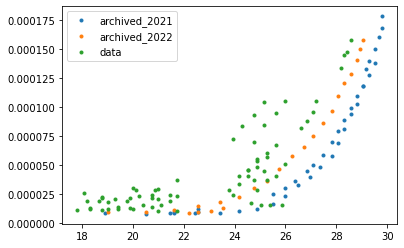

In [88]:
#plt.plot(arch_temp_2020, arch_darks_2020, '.', label = 'archived_2020')    
plt.plot(arch_temp_2021, arch_darks_2021, '.', label = 'archived_2021')
plt.plot(arch_temp_2022, arch_darks_2022, '.', label = 'archived_2022')
plt.plot(data_temp, data_darks, '.', label = 'data')
plt.legend()

In [81]:
data_temp = []
data_darks = []
visit_lst = [1, 3, 4, 5, 7, 8, 9, 10, 56, 57, 58]
for visit_num in visit_lst:
    l = []
    t = []
    for item in flaged_lst:
        file = fits.open(item)
        exptime = file[0].header['EXPTIME']
        temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
        year = (file[0].header['DATE-OBS'])
        data_ps = file[1].data/ exptime
        visit = int(file[0].header['LINENUM'][:2])
        
        if visit == visit_num:
            print(visit_num, year)

            t.append(temp)
            sample = data_ps[471:822 , 471:822]
            #sample = data_ps
            darks = sum(sum(sample)) /( (len(sample) * len(sample[0])) - (2*e)**2)
            l.append(darks)
    data_darks.append(l)
    data_temp.append(t)

1 2021-05-27
1 2021-05-27
1 2021-05-27
1 2021-05-27
1 2021-05-27
1 2021-05-27
1 2021-05-27
3 2021-06-13
3 2021-06-12
3 2021-06-12
3 2021-06-13
3 2021-06-13
4 2021-12-13
4 2021-12-13
4 2021-12-13
4 2021-12-13
4 2021-12-13
4 2021-12-13
4 2021-12-13
4 2021-12-13
7 2021-12-15
7 2021-12-15
7 2021-12-15
7 2021-12-15
8 2022-04-19
8 2022-04-19
8 2022-04-19
8 2022-04-19
8 2022-04-19
8 2022-04-19
8 2022-04-19
8 2022-04-19
9 2022-04-19
9 2022-04-19
9 2022-04-19
9 2022-04-19
9 2022-04-19
9 2022-04-19
9 2022-04-19
9 2022-04-19
10 2022-04-20
10 2022-04-20
10 2022-04-20
10 2022-04-20
10 2022-04-20
10 2022-04-20
10 2022-04-20
10 2022-04-20
56 2021-12-16
56 2021-12-16
56 2021-12-16
56 2021-12-16
56 2021-12-16
56 2021-12-16
56 2021-12-16
56 2021-12-16
57 2021-12-17
57 2021-12-17
57 2021-12-17
57 2021-12-17
57 2021-12-17
57 2021-12-17
57 2021-12-17
57 2021-12-17
58 2022-06-10
58 2022-06-10
58 2022-06-10
58 2022-06-10
58 2022-06-10
58 2022-06-10
58 2022-06-10
58 2022-06-10


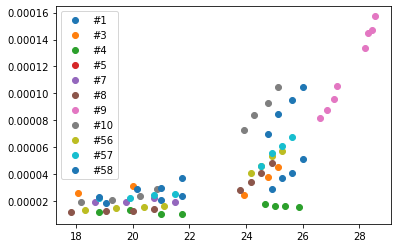

In [82]:
for i in range(len(data_darks)):
    plt.plot(data_temp[i], data_darks[i], 'o', label = '#'+str(visit_lst[i]))
    plt.legend()
    #plt.show()

In [83]:
file = fits.open(flaged_lst[1])
file[0].header

SIMPLE  =                    T / data conform to FITS standard                  
BITPIX  =                   16 / bits per data value                            
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / File may contain standard extensions           
NEXTEND =                    3 / Number of standard extensions                  
GROUPS  =                    F / image is in group format                       
DATE    = '2022-04-13'         / date this file was written (yyyy-mm-dd)        
FILENAME= 'jec403jhq_raw.fits                     ' / name of file              
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'                / telescope used to acquire data                 
INSTRUME= 'ACS   '             / identifier for instrument used to acquire data 
EQUINOX =               2000

In [20]:
%%time
sumdata_1subtracted = np.zeros((1024,1024))
exptime_table = np.zeros((1024,1024))
idx = 0
for filename in flaged_lst:
        file = fits.open(filename)
        data = file[1].data
        flaged_table = file['FLAG'].data
        flaged_subtracted = file['FS'].data
        exptime = file[0].header['EXPTIME']
        temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
        
        if temp > 24.0:
            continue
        idx += 1
        exptime_table += exptime * flaged_table
        sumdata_1subtracted += flaged_subtracted
        #print(file[0].header['DATE'])
for i in range(0, 1024):
    for j in range(0, 1024):
        sumdata_1subtracted[i][j] /= exptime_table[i][j]

print(idx)
Primary = fits.PrimaryHDU()
SCI = fits.ImageHDU(sumdata_1subtracted, name = 'SCI')
hdul = fits.HDUList([Primary, SCI])
hdul.writeto('avg_dark_summed_data_uptemp24.fits', overwrite = True)

38
CPU times: user 839 ms, sys: 142 ms, total: 981 ms
Wall time: 1.76 s


In [101]:
%%time
sumdata_1subtracted = np.zeros((1024,1024))
exptime_table = np.zeros((1024,1024))
num_files_combined = 0
for filename in flaged_lst:
    file = fits.open(filename)
    data = file[1].data
    flaged_table = file['FLAG'].data
    flaged_subtracted = file['FS'].data
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
        
    if temp > 24.0:
        continue
    num_files_combined += 1
    exptime_table += exptime * flaged_table
    sumdata_1subtracted += flaged_subtracted
        
#for filename in dark_lst:
#    file = fits.open(filename)
#    data = file[1].data
#    exptime = file[0].header['EXPTIME']
#    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
#    flaged_table = np.ones((1024, 1024))
#    year = int(file[0].header['DATE-OBS'][:4])
#    if temp <= 24.0 and year >= 2021:
#        num_files_combined += 1
#        exptime_table += exptime * flaged_table
#        sumdata_1subtracted += data

for i in range(0, 1024):
    for j in range(0, 1024):
        sumdata_1subtracted[i][j] /= exptime_table[i][j]

print(num_files_combined)
Primary = fits.PrimaryHDU()
SCI = fits.ImageHDU(sumdata_1subtracted, name = 'SCI')
hdul = fits.HDUList([Primary, SCI])
hdul.writeto('primary_dark_uptemp24.fits', overwrite = True)

38
CPU times: user 784 ms, sys: 159 ms, total: 943 ms
Wall time: 1.78 s


In [91]:
pri_dark = fits.open('primary_dark_uptemp24.fits')
real_dark = fits.open('avg_dark_summed_data.fits')

pri_dark_data = pri_dark[1].data
real_dark_data = real_dark[1].data

data = real_dark_data - pri_dark_data
Primary = fits.PrimaryHDU(data)
hdul = fits.HDUList([Primary])
hdul.writeto('secondary_dark.fits', overwrite = True)

In [100]:
pri_dark = fits.open('primary_dark_uptemp24.fits')
data_file = fits.open('flaged/jec401nxq_flaged.fits')
exptime = data_file[0].header['EXPTIME']
temp = (data_file[1].header['MDECODT1'] + data_file[1].header['MDECODT2']) /2 
dark_data = pri_dark[1].data
real_data = data_file[1].data
print(temp)

data = real_data - dark_data * exptime 
Primary = fits.PrimaryHDU(data)
hdul = fits.HDUList([Primary])
hdul.writeto('jec401nxq_primary_dark_subtracted.fits', overwrite = True)

21.7218


In [85]:
pri_dark = fits.open('primary_dark_uptemp24.fits')
real_dark = fits.open('avg_dark_summed_data.fits')

pri_dark_data = pri_dark[1].data
real_dark_data = real_dark[1].data

data = real_dark_data - pri_dark_data
Primary = fits.PrimaryHDU(data)
hdul = fits.HDUList([Primary])
hdul.writeto('real_minus_primary.fits', overwrite = True)

In [99]:
coeff = 0.2
pri_dark = fits.open('primary_dark_uptemp24.fits')
sec_dark = fits.open('secondary_dark.fits')
data_file = fits.open('flaged/jec401nxq_flaged.fits')

exptime = data_file[0].header['EXPTIME']
temp = (data_file[1].header['MDECODT1'] + data_file[1].header['MDECODT2']) /2 
pri_dark_data = pri_dark[1].data
sec_dark_data = sec_dark[0].data
real_data = data_file[1].data
print(temp)

data = real_data -  pri_dark_data * exptime - coeff * sec_dark_data * exptime
Primary = fits.PrimaryHDU(data)
hdul = fits.HDUList([Primary])
hdul.writeto('jec401nxq_dark_subtracted_0.5.fits', overwrite = True)

21.7218


In [90]:
pri_dark = fits.open('primary_dark_uptemp24.fits')
data_file = fits.open('flaged/jec401nxq_flaged.fits')

exptime = data_file[0].header['EXPTIME']
temp = (data_file[1].header['MDECODT1'] + data_file[1].header['MDECODT2']) /2 
dark_data = pri_dark[1].data
real_data = data_file[1].data
print(temp)

data = real_data -  dark_data * exptime 
Primary = fits.PrimaryHDU(data)
hdul = fits.HDUList([Primary])
hdul.writeto('jec401nxq_dark_subtracted.fits', overwrite = True)

21.7218
